## Calculate NPP timeseries Statistics for CBNMS ##

Based on feedback from Dani L.
- Asked for errorbars for NPP plots
- Space (across the region)
- Time (across the month)

output a timeseries (`.csv`):
- mean, median, std, number of cells for each day

In [44]:
import salem
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd


__Create a Dask Client__
On laptop run:
`ssh -N -f -L localhost:8787:localhost:8787 pdaniel@particle.shore.mbari.org` to forward the client webapp

In [2]:
client = Client(n_workers=25, threads_per_worker=2, memory_limit='2.5GB')
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 25
Total threads: 50,Total memory: 58.21 GiB
Comm: tcp://127.0.0.1:40141,Workers: 25
Dashboard: http://127.0.0.1:8787/status,Total threads: 50
Started: Just now,Total memory: 58.21 GiB
Comm: tcp://127.0.0.1:38545,Total threads: 2
Dashboard: http://127.0.0.1:33501/status,Memory: 2.33 GiB
Nanny: tcp://127.0.0.1:43855,


In [10]:
# Weird Bug here, but make sure to run this first
sanctuary_outline= salem.read_shapefile('./shapefiles/cbnms_py2/CBNMS_py.shp')
sanctuary_outline.crs = 'epsg:4326'
bbox = ((sanctuary_outline['max_y'].max(),sanctuary_outline['min_y'].min()),(sanctuary_outline['max_x'].max(),sanctuary_outline['min_x'].min()))

In [11]:
bbox

((38.29989002536195, 37.76686983431216),
 (-123.08237000000003, -123.99988000105128))

Load Data - Choosing a chunck size and bounding the data before masking is way faster

In [37]:
ds = xr.open_mfdataset("./npp/daily/*.nc",chunks={"lat": 100, "lon":100, "time":10})
ds = ds.sel(lat=slice(bbox[0][0],bbox[0][1]), lon=slice(bbox[1][1],bbox[1][0]))

In [6]:
# Mask Data with CBNMS shapefile
dsr = ds.salem.roi(shape=sanctuary_outline, all_touched=True)

In [7]:
npp_daily_mean = dsr.mean(dim=['lat', 'lon'])['npp'].values
npp_daily_std = dsr.std(dim=['lat', 'lon'])['npp'].values
npp_daily_count = dsr.count(dim=['lat', 'lon'])['npp'].values
date = dsr['time'].values

__Save data as a csv__

In [36]:
df = pd.DataFrame(data={"npp_mean":npp_daily_mean, "npp_std":npp_daily_std, "npp_count":npp_daily_count, "date":date})
df.to_csv("cbnms_npp_daily.csv", index=False)

__Save an example Plot__

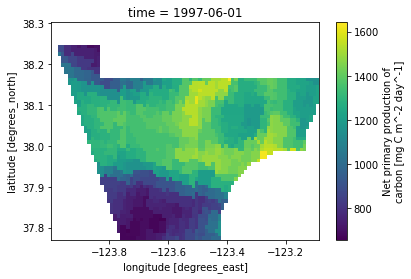

In [46]:
ax = dsr['npp'].isel(time=200).plot()
plt.savefig('daily-npp-cbnms.png',dpi=200)